In [1]:
import torch
from torch import nn
import numpy as np
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer
import datasets
from torch.utils.data import DataLoader
from itertools import islice
from tqdm import tqdm
import gc
from matplotlib import pyplot as plt
from datasets import load_dataset, Dataset

In [2]:
model = AutoModelForCausalLM.from_pretrained('gpt2').to('cuda')

In [4]:
test = datasets.load_from_disk('/workspace/corpus/msmarco/msmarco_GPT2_64tokens_1m/test').with_format('torch', device='cuda')
loader = DataLoader(test, batch_size=128)

In [3]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')
Token = {v: k for k, v in tokenizer.get_vocab().items()}

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [6]:
tokenizer(tokenizer.bos_token)

{'input_ids': [50256], 'attention_mask': [1]}

In [72]:
torch.set_grad_enabled(False)

In [73]:
gc.collect()
torch.cuda.empty_cache()

In [22]:
loss = 0
for batch in tqdm(iter(loader)):
    out = model(
        input_ids=batch['input_ids'],
        attention_mask=batch['attention_mask'],
        labels=batch['input_ids'],
    )
    loss += out.loss

100%|██████████| 704/704 [04:02<00:00,  2.90it/s]


In [23]:
loss / 704

tensor(3.6992, device='cuda:0')

In [9]:
idxs = []
i = 1
while i <= 960:
    idxs.append(i)
    i = int(1.2 * i) + 1
idxs.insert(0, 0)

In [ ]:
idxs = list(range(50))

In [101]:
losses = []
num_batches = 10
ce = nn.CrossEntropyLoss(reduction='none')
for start_pos in tqdm(idxs):
    cur_loss = []
    for batch in islice(iter(loader), num_batches):
        out = model(
            input_ids=batch['input_ids'],
            position_ids=torch.arange(start_pos, start_pos + 64, device='cuda').unsqueeze(0),
            attention_mask=batch['attention_mask'],
            #labels=batch['input_ids'],
        )
        cur_loss.append(ce(
            out.logits[:,-64:-1,:].transpose(1, 2),
            batch['input_ids'][:,1:],
        ).mean(dim=1))
    losses.append(torch.concat(cur_loss))

100%|██████████| 32/32 [01:51<00:00,  3.49s/it]


In [87]:
losses[0].shape

torch.Size([80640])

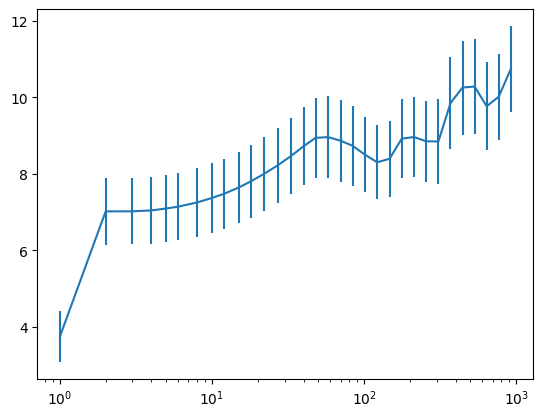

In [110]:
plt.errorbar(idxs+1, [l.mean().item() for l in losses], yerr=[l.std().item() for l in losses])
plt.xscale('log')
plt.show()

In [97]:
losses[0].min()

tensor(1.4305e-06, device='cuda:0')

In [ ]:
idxs = idxs[:

In [11]:
from collections import defaultdict
loss0 = defaultdict(lambda: 0)
loss1 = defaultdict(lambda: 0)
bos = 50256
num_batches = 5
ce = nn.CrossEntropyLoss()#(reduction='none')
for leftpad in tqdm(idxs):
    id_pad = torch.full((128, leftpad), bos).to('cuda')
    mask_pad0 = torch.full((128, leftpad), 0).to('cuda')
    mask_pad1 = torch.full((128, leftpad), 1).to('cuda')
    cur_loss = []
    for batch in islice(iter(loader), num_batches):
        out0 = model(
            input_ids=torch.concat(
                [id_pad, batch['input_ids']], 
                axis=1
            ),
            attention_mask=torch.concat(
                [mask_pad0, batch['attention_mask']], 
                axis=1
            )
        )
        loss0[leftpad] += ce(
            out0.logits[:,-64:-1,:].contiguous().view(-1, out0.logits.shape[-1]),
            batch['input_ids'][:,1:].contiguous().view(-1)
        ).item()
        del out0
        gc.collect()
        torch.cuda.empty_cache()
        out1 = model(
            input_ids=torch.concat(
                [id_pad, batch['input_ids']], 
                axis=1
            ),
            attention_mask=torch.concat(
                [mask_pad1, batch['attention_mask']], 
                axis=1
            )
        )
        loss1[leftpad] += ce(
            out1.logits[:,-64:-1,:].contiguous().view(-1, out1.logits.shape[-1]),
            batch['input_ids'][:,1:].contiguous().view(-1)
        ).item()
        del out1
        gc.collect()
        torch.cuda.empty_cache()
    loss0[leftpad] /= num_batches
    loss1[leftpad] /= num_batches

100%|██████████| 32/32 [04:50<00:00,  9.07s/it]


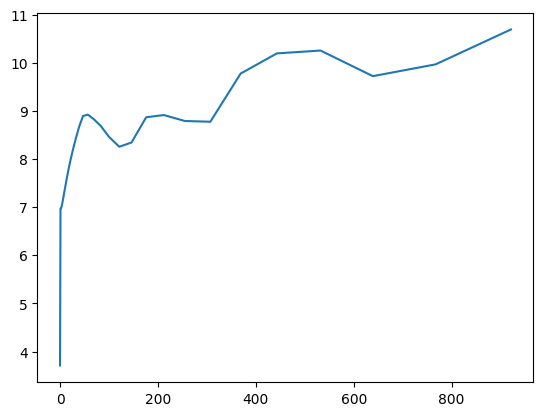

In [13]:
plt.plot(idxs, loss0.values())
plt.show()

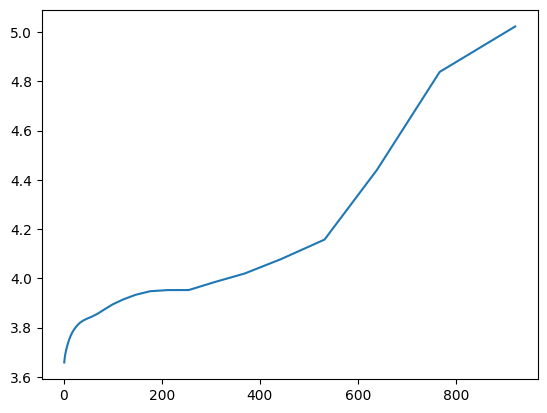

In [34]:
plt.plot(idxs[1:], list(loss1.values())[1:])
plt.show()

In [36]:
loss1[0], loss1[1]

(3.7095064163208007, 3.6583018779754637)

In [31]:
from collections import defaultdict
loss = defaultdict(lambda: 0)
bos = 50256
num_batches = 20
ce = nn.CrossEntropyLoss()#(reduction='none')
for start_pos in tqdm(idxs[1:]):
    id_pad = torch.full((128, 1), bos).to('cuda')
    mask_pad = torch.full((128, 1), 1).to('cuda')
    pos_pad = torch.full((1,), 0).to('cuda')
    for batch in islice(iter(loader), num_batches):
        out = model(
            input_ids=torch.concat(
                [id_pad, batch['input_ids']], 
                axis=1
            ),
            position_ids = torch.concat(
                [pos_pad, torch.arange(start_pos, start_pos+64, device='cuda')]
            ).unsqueeze(0),
            attention_mask=torch.concat(
                [mask_pad, batch['attention_mask']], 
                axis=1
            ),
        )
        loss[start_pos] += ce(
            out.logits[:,-64:-1,:].contiguous().view(-1, out.logits.shape[-1]),
            batch['input_ids'][:,1:].contiguous().view(-1)
        ).item()
        gc.collect()
        torch.cuda.empty_cache()
    loss[start_pos] /= num_batches

100%|██████████| 31/31 [03:44<00:00,  7.24s/it]


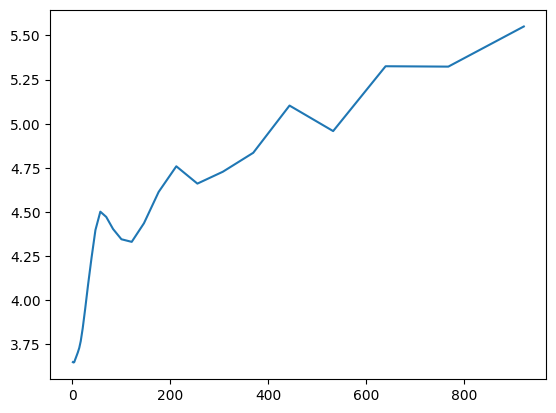

In [33]:
plt.plot(idxs[1:], loss.values())
plt.show()

In [37]:
loss[1], loss[2]

(3.6491192102432253, 3.6470759749412536)

In [44]:
import urllib.request
url = 'https://www.gutenberg.org/cache/epub/73040/pg73040.txt'
text = urllib.request.urlopen(url).read().decode('utf-8')

In [45]:
# remove newlines (gutenberg has line wrapping)
import re
text = re.sub('[\\r\\n]+', ' ', text)
# remove frontmatter
text = text[3458:]
# remove chapter headings
text = re.sub('CHAPTER [0-9A-Z ]+ ', '\\n\\n', text)

In [ ]:
ds = load_dataset('pg19', split='validation' , streaming=True)

In [50]:
tokens = tokenizer(text, return_tensors='pt').to('cuda')

In [52]:
tokens['input_ids'].shape

torch.Size([1, 138850])

In [53]:
tokens.keys()

dict_keys(['input_ids', 'attention_mask'])

In [86]:
gc.collect()
torch.cuda.empty_cache()

In [95]:
import random
from collections import defaultdict

num_batches = 1000
batch_size = 32
ce = nn.CrossEntropyLoss(reduction='none')
loss = 0

for _ in tqdm(range(num_batches)):
    batch = defaultdict(lambda: [])
    for _ in range(batch_size):
        a = random.randint(1024, tokens['input_ids'].shape[-1] - 2048)
        for k in tokens.keys():
            # one extra so that we have loss for last
            batch[k].append(torch.take(tokens[k], torch.arange(a, a + 1025, device='cuda')))
    
    for k in tokens.keys():
        batch[k] = torch.stack(batch[k])

    out = model(**{k: batch[k][:,:-1] for k in batch})
    loss += ce(
        out.logits.transpose(1, 2),
        batch['input_ids'][:,1:]
    ).mean(dim=0)
    gc.collect()
    torch.cuda.empty_cache()
loss /= num_batches

100%|██████████| 1000/1000 [16:54<00:00,  1.01s/it]


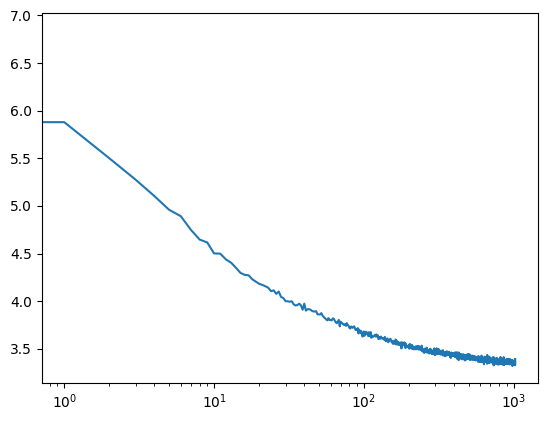

In [105]:
plt.plot(loss.cpu().numpy())
plt.xscale('log')
plt.show()

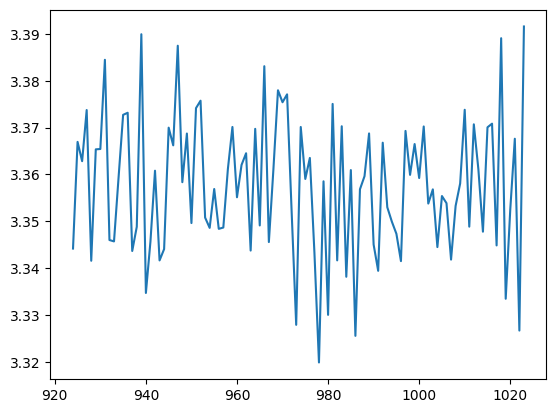

In [100]:
plt.plot(list(range(1024))[-100:], loss[-100:].cpu().numpy())
plt.show()